## Exercise-1: Data Preparation 
### Q1.1 Load the dataset, inspect feature names and target distribution. Comment on dataset imbalance. 
We start by importing the dataset from sci-kit learn, and inspects the feature names.

In [914]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(42)

# Load the breast cancer dataset
cancer_data = load_breast_cancer()

# Extract the feature names
feature_names = cancer_data.feature_names
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Then, we check the distribution of the target classes.

In [915]:
# Compute counts and percentages
counts = np.bincount(cancer_data.target)
percentages = counts / counts.sum() * 100

# Print clean output
for name, count, pct in zip(cancer_data.target_names, counts, percentages):
    print(f"{name}: {count} ({pct:.2f}%)")

malignant: 212 (37.26%)
benign: 357 (62.74%)


To visualize this, we plot the data into a pie chart.

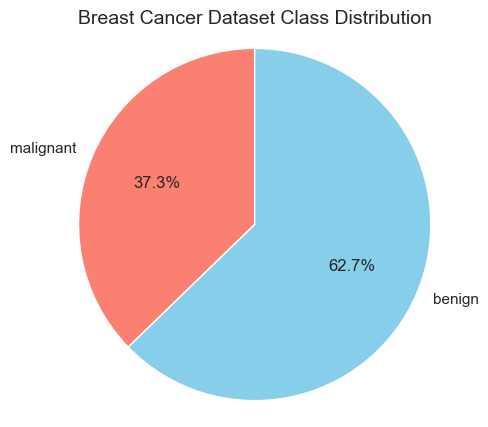

In [916]:
# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    counts,
    labels=cancer_data.target_names,
    autopct="%1.1f%%",
    startangle=90,
    colors=["salmon", "skyblue"],
)
plt.title("Breast Cancer Dataset Class Distribution", fontsize=14)
plt.axis("equal")  # Equal aspect ratio ensures the pie is circular
plt.show()

By inspecting the feature names and target distribution, we notice that the dataset is somewhat imbalanced. The `benign` class has ~1.7 times more samples than `malignant`. 

We can employ *stratified sampling* to make shure both classes are represented in each train/test split.

### Q1.2 Analyze all features with and without standardization (i.e., zero mean and unit variance). Plot the feature analysis with and without standardization and decide which version is more suitable. 
We start by standardizing the data using the `StandardScaler`.

In [917]:
# Raw data
X = cancer_data.data
y = cancer_data.target

# Standardized data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We them plot the two different distributions, to analyse the differences.

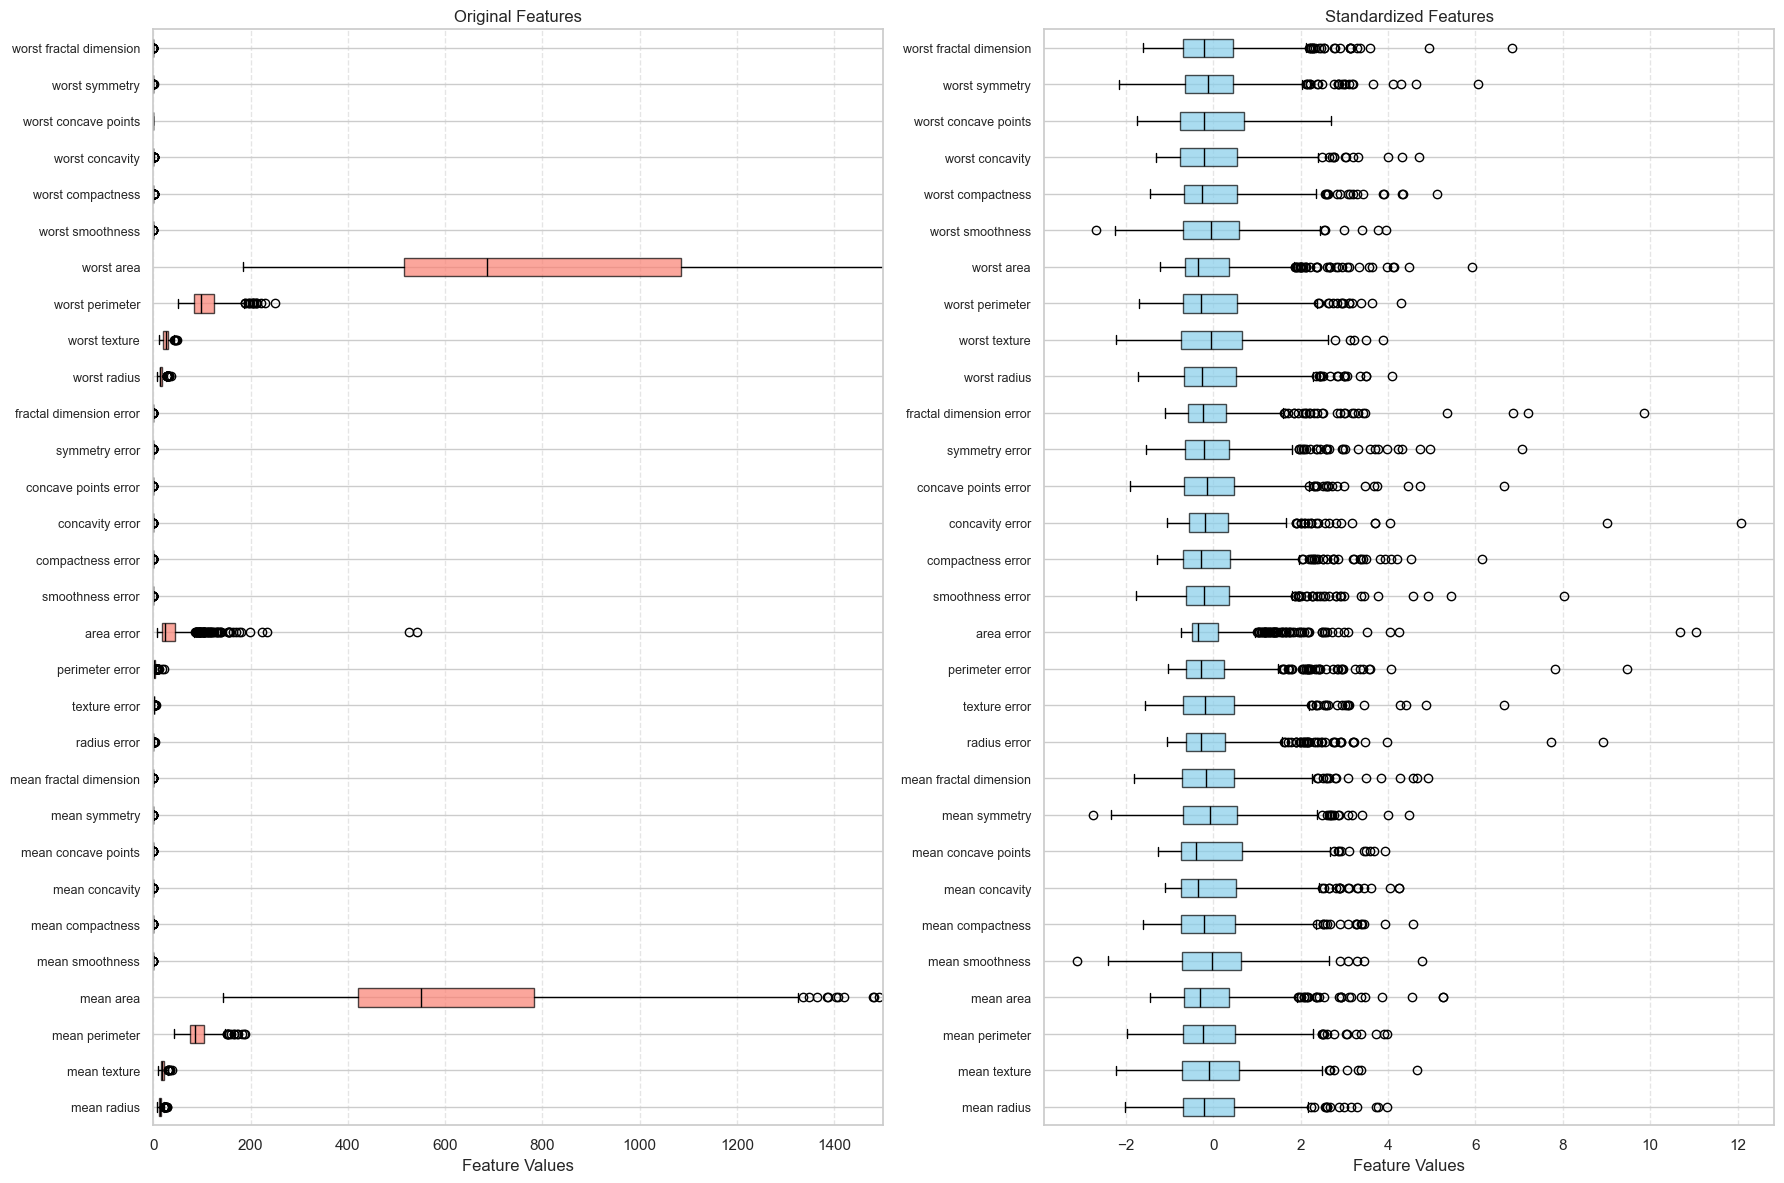

In [918]:
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# Original features
axes[0].boxplot(X, vert=False, patch_artist=True,
                boxprops=dict(facecolor='salmon', alpha=0.7),
                medianprops=dict(color='black'))
axes[0].set_title("Original Features")
axes[0].set_xlabel("Feature Values")
axes[0].set_yticks(range(1, len(feature_names) + 1))
axes[0].set_yticklabels(feature_names, fontsize=9)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)
axes[0].set_xlim(left=0, right=1500)  # zoom in to avoid big outliers stretching the plot

# Standardized features
axes[1].boxplot(X_scaled, vert=False, patch_artist=True,
                boxprops=dict(facecolor='skyblue', alpha=0.7),
                medianprops=dict(color='black'))
axes[1].set_title("Standardized Features")
axes[1].set_xlabel("Feature Values")
axes[1].set_yticks(range(1, len(feature_names) + 1))
axes[1].set_yticklabels(feature_names, fontsize=9)
axes[1].grid(axis='x', linestyle='--', alpha=0.5)
# No xlim on standardized features, since they are nicely scaled

plt.tight_layout()
plt.show()


In the original features, `worst area` and `mean area` have much larger scales compared to others, which causes them to dominate the dataset visually and statistically.

### Q1.3 Comment on importance of three way split with respect to hyperparameter search and robustness of any learned model. 

Splitting the dataset into training, validation, and testing sets is crucial for building a robust model and effectively tuning its hyperparameters. This approach is particularly important due to the black-box nature of many machine learning models.

The test set should remain untouched during model training and hyperparameter tuning, providing an unbiased estimate of the model’s generalization ability. The validation set plays a key role in hyperparameter search, as it helps assess how well the model is performing during tuning and ensures that the selected hyperparameters improve model performance.

## Exercise-2: Decision Trees 
### Q2.1 Train a Decision Tree classifier using default parameters. Evaluate it on validation sets from original splits (report accuracy mean and std).
We start by creating the model, using a pipeline. The `StandardScaler` is not required, but it is usefull when comparing to other models.

In [919]:
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline

dtree_model = Pipeline([
    ("scaler", StandardScaler()), # Optional, but handy for consistency
    ("d_tree", DecisionTreeClassifier())
])

Then, we split the dataset into 60% training, 20% validation, and 20% testing.
The stratify parameter ensures that all classes are represented proportionally in each split, preserving the class distribution across the subsets.

In [920]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% of the data for testing
    random_state=42,    # for reproducibility
    shuffle=True,       # randomize before splitting
    stratify=y          # optional, keeps class proportions the same in each set
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,     # 20% of the data for validation
    random_state=42,    # for reproducibility
    shuffle=True,       # randomize before splitting
    stratify=y_temp     # optional, keeps class proportions the same in each set
)

To report the accuracy mean and standard deviation, we use 5-fold cross-validation.

In [921]:
cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model_cv(X_train, y_train, model):

    acc_score, roc_curves = [], []
        
    for train_index, test_index in cross_validation.split(X_train, y_train):

        # Select the training data for this fold
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Train the Decision Tree model on the current fold's training data
        model.fit(X_train_fold, y_train_fold)

        # Predict labels and probabilities
        y_pred = model.predict(X_test_fold)
        y_prob = model.predict_proba(X_test_fold)[:, 1]  # Prob for class 1
        
        # Accuracy
        acc = accuracy_score(y_test_fold, y_pred)
        acc_scores.append(acc)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
        roc_auc = auc(fpr, tpr)
        roc_curves.append((fpr, tpr, roc_auc))
    
    return acc_scores, roc_curves

dtree_acc_scores, dtree_roc_curves = evaluate_model_cv(X_train, y_train, dtree_model)

# Calculate the mean and standard deviation of the accuracy scores
mean_acc = np.mean(dtree_acc_scores)
std_acc = np.std(dtree_acc_scores)

print(f"Validation Accuracy (mean ± std): {mean_acc:.3f} ± {std_acc:.3f}")

Validation Accuracy (mean ± std): 0.951 ± 0.030


The model has a mean accuracy of approximately ~94%. This indicates that the Decision Tree is effectively capturing the underlying patterns in the data and performing well on the validation set.

The low standard deviation of ~3% suggests that the model is stable across different folds, with minimal variation in performance. This means the model generalizes well and is not highly sensitive to the specific split of the data, which is a good sign that it is not overfitting.

### Q2.2 From the trained model, comment on feature importance values and identify the top 3 features from your model. 
To identify the top 3 most important features, we can extract the feature importances directly from the model.

In [922]:
# Create a DataFrame with feature names and their importance scores
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dtree_model.named_steps["d_tree"].feature_importances_
})

# Sort in descending order
feature_importance = (
    feature_importance.round(3)
    .sort_values(by="Importance", ascending=False)
    .reset_index(drop=True)                                      
)

# Adjust index to start from 1 to represent rank order
feature_importance.index += 1

# Display top 3 most important features
feature_importance.head(3)

,Feature,Importance
1,worst concave points,0.722
2,worst area,0.109
3,worst radius,0.058


Based on the feature importance values from the trained decision tree model, `worst concave points` is the most dominant feature, contributing ~72% of the model's decision-making. The second most important feature is `worst area` (~11%), followed by `mean perimeter` (~6%). 

These three features together account for the majority of the model’s predictive power, indicating that they are the key drivers in distinguishing between classes in the dataset.

### Q2.3 Vary the max depth parameter (e.g., depth 2-10). Use validation accuracy (mean ± std from cross-validation on the training set) to choose the best depth. Provide performance for each chosen depth (at-least 5 to be reported) and discuss the aspects of overfitting vs. underfitting.
We start the hyperparameter tuning by using `GridSearchCV` with depths ranging from 1 to 12.

In [923]:
# Define the grid of parameters to search
param_grid = {
    "d_tree__max_depth": list(range(1, 13))  # depths 1 through 12
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    dtree_model,
    param_grid,
    cv=cross_validation,        
    scoring="accuracy",    
    return_train_score=True
)

# Fit to your data
grid_search.fit(X_train, y_train)

print(f"Validation accuracy of the best model: {grid_search.best_estimator_.score(X_val, y_val):.3f}")

Validation accuracy of the best model: 0.939


To better understand how the depth of the decision tree impacts the model's performance, we plot the the training and cross-validation accuracy.

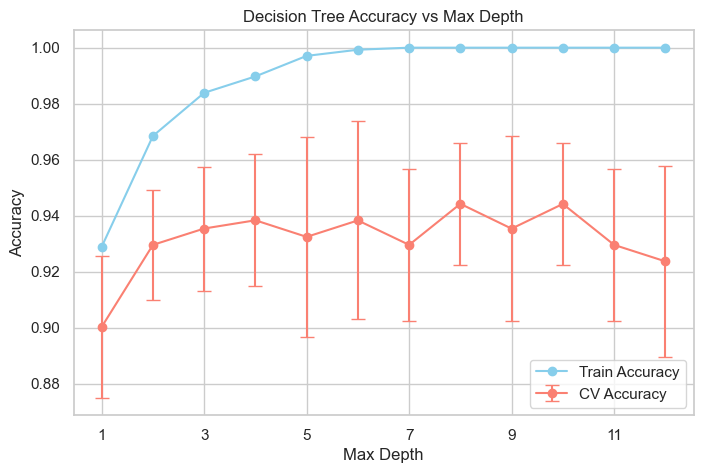

In [924]:
# Extract results from grid search
max_depth_res = grid_search.cv_results_['param_d_tree__max_depth']
mean_train_res = grid_search.cv_results_['mean_train_score']
mean_test_res = grid_search.cv_results_['mean_test_score']
std_test_res = grid_search.cv_results_['std_test_score']  # Standard deviation for error bars

# Plotting
plt.figure(figsize=(8, 5))

# Plot train accuracy (skyblue)
plt.plot(max_depth_res, mean_train_res, 'o-', label='Train Accuracy', color='skyblue')

# Plot cross-validation accuracy with error bars (salmon)
plt.errorbar(max_depth_res, mean_test_res, yerr=std_test_res, fmt='o-', label='CV Accuracy', color='salmon', capsize=5)

# Add labels and title
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')

# Customizing x-ticks
plt.xticks([1, 3, 5, 7, 9, 11])

# Display grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


As the maximum depth increases, train accuracy approaches 1.0, indicating overfitting. The model begins to memorize the training data and fits noise, which harms its ability to generalize to unseen data. This results in high accuracy on the training set but poor performance on new data.

CV accuracy initially improves with depth, showing better generalization. However, after a certain point, it plateaus or fluctuates. The overlapping error bars suggest that these fluctuations are likely due to randomness in the data rather than actual improvements in model performance.

At lower depths (e.g., depth = 1), both train and CV accuracies are low, indicating underfitting. The model is too simple to capture the complexity of the data, leading to poor performance on both the training and validation sets.

### Q2.4 Repeat previous exercise with different min samples leaf values. Which setting generalizes best according to the validation set?

In [925]:
# Define the grid of parameters to search
param_grid = {
    "d_tree__min_samples_leaf": list(range(1, 13))  # depths 1 through 12
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    dtree_model,
    param_grid,
    cv=cross_validation,        
    scoring="accuracy",    
    return_train_score=True
)

# Fit to your data
grid_search.fit(X_train, y_train)

print(f"Validation accuracy of the best model: {grid_search.best_estimator_.score(X_val, y_val):.3f}")

Validation accuracy of the best model: 0.965


To better understand how the minimum saples of leaf nodes impacts the model's performance, we plot the the training and cross-validation accuracy.

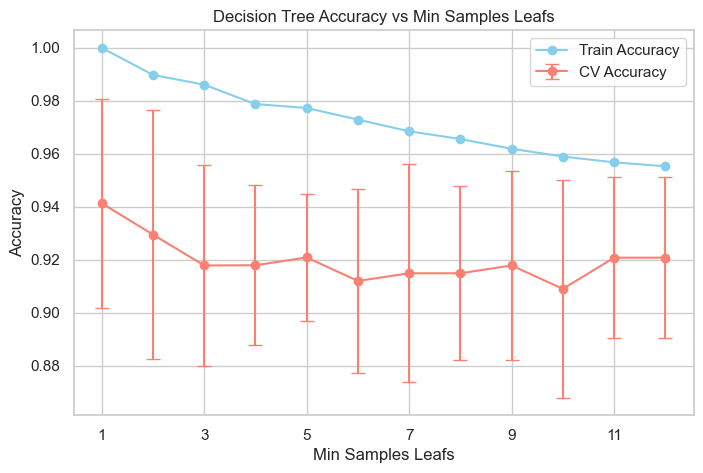

In [926]:
# Extract results from grid search
max_depth_res = grid_search.cv_results_['param_d_tree__min_samples_leaf']
mean_train_res = grid_search.cv_results_['mean_train_score']
mean_test_res = grid_search.cv_results_['mean_test_score']
std_test_res = grid_search.cv_results_['std_test_score']  # Standard deviation for error bars

# Plotting
plt.figure(figsize=(8, 5))

# Plot train accuracy (skyblue)
plt.plot(max_depth_res, mean_train_res, 'o-', label='Train Accuracy', color='skyblue')

# Plot cross-validation accuracy with error bars (salmon)
plt.errorbar(max_depth_res, mean_test_res, yerr=std_test_res, fmt='o-', label='CV Accuracy', color='salmon', capsize=5)

# Add labels and title
plt.xlabel('Min Samples Leafs')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Min Samples Leafs')

# Customizing x-ticks
plt.xticks([1, 3, 5, 7, 9, 11])

# Display grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


As the minimum number of samples required for a leaf node increases, train accuracy decreases. This indicates that a higher sample requirement simplifies the model and reduces overfitting.

The highest mean accuracy occurs when `min_samples_leaf` = 1, but we observe that train accuracy is 1.0, with a high standard deviation in CV accuracy. This suggests that the model overfits the data.

Around `min_samples_leaf` = 5, the model stabilizes with a more consistent CV accuracy and lower standard deviation, indicating better generalization. Increasing the minimum samples beyond this point leads to a decrease in train accuracy, suggesting potential underfitting.

## Exercise-3: Support Vector Machines (SVM) 
### Q3.1 Train a linear SVM (kernel="linear") and evaluate on validation sets (use the original 5 splits that was created in previous exercise). Report accuracy mean, std and plot the ROC for each split. 
First, we create a SVM model, using a linear kernel, with `SVC`.

In [927]:
from sklearn.svm import SVC
from scipy import stats


svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel='linear', probability=True, random_state=42))
])

We then compute the accuracy scores and roc curves for each fold on the cross-validation.

In [928]:
linear_acc_scores, linear_roc_curves = evaluate_model_cv(X_train, y_train, svm_model)

# Calculate the mean and standard deviation of the accuracy scores
mean_acc = np.mean(linear_acc_scores)
std_acc = np.std(linear_acc_scores)

print(f"Validation Accuracy (mean ± std): {mean_acc:.3f} ± {std_acc:.3f}")

Validation Accuracy (mean ± std): 0.951 ± 0.030


Lastly, we plot the ROC curves.

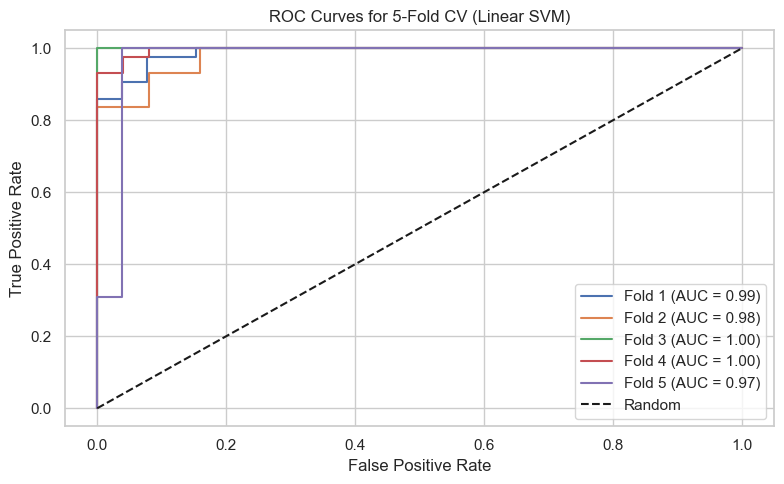

In [929]:
def plot_roc_curves_cv(roc_curves):

    # Plot ROC curves for all folds
    plt.figure(figsize=(8, 5))
    for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
        plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

    # Plot reference line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # Plot formatting
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 5-Fold CV (Linear SVM)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curves_cv(linear_roc_curves)

The ROC curves for all folds indicate strong model performance, with the curves positioned near the top-left corner, suggesting high accuracy. The stepped shape of the curves is likely due to the linear SVM kernel, which produces discrete decision boundaries. Despite the stepping, the AUC values are close to 1 for all folds, indicating excellent classification performance.

### Q3.2 Train an Radial Basis Function (RBF) kernel SVM. Compare its performance to the linear kernel using validation accuracy. Plot ROC for these models. 
We start by creating the SVM with an RBF kernel.

In [930]:
rbf_svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rbf_svm", SVC(kernel='rbf', probability=True, random_state=42))
])

rbf_acc_scores, rbf_roc_curves = evaluate_model_cv(X_train, y_train, rbf_svm_model)

# Calculate the mean and standard deviation of the accuracy scores
mean_acc = np.mean(rbf_acc_scores)
std_acc = np.std(rbf_acc_scores)

print(f"Validation Accuracy (mean ± std): {mean_acc:.3f} ± {std_acc:.3f}")

Validation Accuracy (mean ± std): 0.952 ± 0.030


Then we plot the ROC curves.

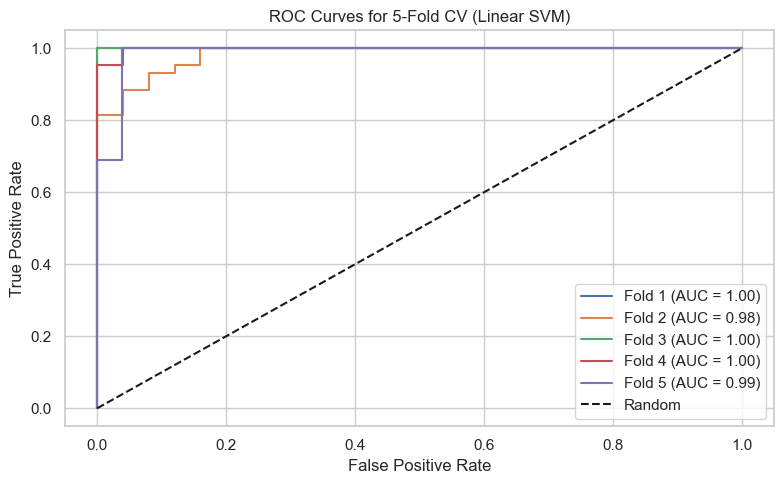

In [931]:
plot_roc_curves_cv(rbf_roc_curves)

Lastly, we check if there is a statistically significant difference between the two models. This is done by conducting a t-test.

In [932]:
# Extract AUC values (last element in each tuple)
auc_linear = [roc_auc for _, _, roc_auc in linear_roc_curves]
auc_rbf = [roc_auc for _, _, roc_auc in rbf_roc_curves]

def t_test_models(model_1, model_2, alpha=0.05):
    # Perform paired t-test on the AUCs
    t_stat, p_value = stats.ttest_rel(model_1, model_2)

    # Print the results
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.3f}")

    # Interpret the result
    if p_value < alpha:
        print("Statistically significant difference between the two models.")
    else:
        print("No statistically significant difference between the two models.")
    
t_test_models(auc_linear, auc_rbf)

T-statistic: -2.012
P-value: 0.115
No statistically significant difference between the two models.


Based on the t-test, the p-value is greater than the typical significance threshold (α = 0.05). Therefore, we fail to reject the null hypothesis, which suggests no statistically significant difference in validation accuracy between the linear and RBF kernel SVMs.

The difference in performance is small and likely due to randomness in data splits or inherent variability, rather than the choice of kernel.

### Q3.3 Experiment with different values of C (regularization strength). Use the validation set to select the best C. Report results as a plot of accuracy vs. C.
We start by creating a grid search to find the optimal tuning of the hyper parameter *C*.

In [933]:
param_grid = {
    "rbf_svm__C": [10**i for i in range(-2, 3)]  # same as [0.01, 0.1, 1, 10, 100]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    rbf_svm_model,
    param_grid,
    cv=cross_validation,        
    scoring="accuracy",    
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print(f"Validation accuracy of the best model: {grid_search.best_estimator_.score(X_val, y_val):.3f}")

Validation accuracy of the best model: 0.982


Next, we plotted the training and validation accuracies across different values of the regularization parameter *C*.

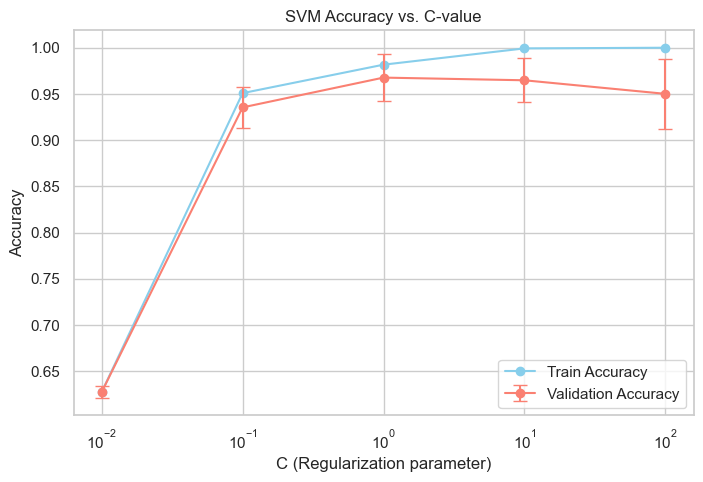

In [934]:
# Extract results from grid search
C_values = grid_search.cv_results_['param_rbf_svm__C']
mean_train_acc = grid_search.cv_results_['mean_train_score']
mean_cv_acc = grid_search.cv_results_['mean_test_score']
std_cv_acc = grid_search.cv_results_['std_test_score']

plt.figure(figsize=(8, 5))

# Plot training accuracy
plt.plot(C_values, mean_train_acc, 'o-', label='Train Accuracy', color='skyblue')

# Plot validation accuracy with error bars
plt.errorbar(C_values, mean_cv_acc, yerr=std_cv_acc, fmt='o-', label='Validation Accuracy', color='salmon', capsize=5)

plt.xscale('log')  # Set x-axis to log scale because C varies exponentially
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy vs. C-value')
plt.grid(True)
plt.legend()

plt.show()

The plot shows how the SVM's training and validation accuracy change with different values of the regularization parameter *C*. At low values of *C*, the model underfits, resulting in low accuracy. Accuracy improves until *C* = 1, after which the validation accuracy drops while the training accuracy remains perfect. This indicates the model starts overfitting for larger values of *C*.

### Q3.4 Experiment with different γ values for the RBF kernel. Discuss the effect on bias-variance trade-off for all experimented values. Select the best γ using the validation set and report the performance on validation set. 


In [935]:
param_grid = {
    "rbf_svm__gamma": [10**i for i in range(-4, 2)]  # same as [1e-4, 1e-3, 0.01, 0.1, 1, 10]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    rbf_svm_model,
    param_grid,
    cv=cross_validation,        
    scoring="accuracy",    
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print(f"Validation accuracy of the best model: {grid_search.best_estimator_.score(X_val, y_val):.3f}")

Validation accuracy of the best model: 0.965


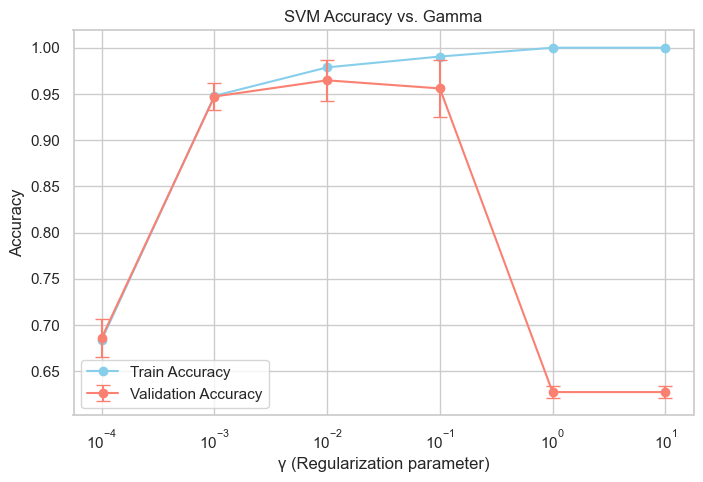

In [936]:
# Extract results from grid search
gamma_values = grid_search.cv_results_['param_rbf_svm__gamma']
mean_train_acc = grid_search.cv_results_['mean_train_score']
mean_cv_acc = grid_search.cv_results_['mean_test_score']
std_cv_acc = grid_search.cv_results_['std_test_score']

plt.figure(figsize=(8, 5))

# Plot training accuracy
plt.plot(gamma_values, mean_train_acc, 'o-', label='Train Accuracy', color='skyblue')

# Plot validation accuracy with error bars
plt.errorbar(gamma_values, mean_cv_acc, yerr=std_cv_acc, fmt='o-', label='Validation Accuracy', color='salmon', capsize=5)

plt.xscale('log')  # Set x-axis to log scale because C varies exponentially
plt.xlabel('γ (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.grid(True)
plt.legend()

plt.show()

The plot shows that very low γ values cause underfitting due to overly smooth decision boundaries, while very high γ values lead to overfitting with poor generalization. The best validation accuracy is achieved at γ = 10⁻², indicating an optimal balance between bias and variance.

## Exercise-4: Model Comparison 
### Q4.1 Compare Decision Tree and SVM results from the training set (cross-validation mean ± std) and validation set. Plot the performance comparison plots (e.g., scatter plots, ROC curves). Which model generalizes better?


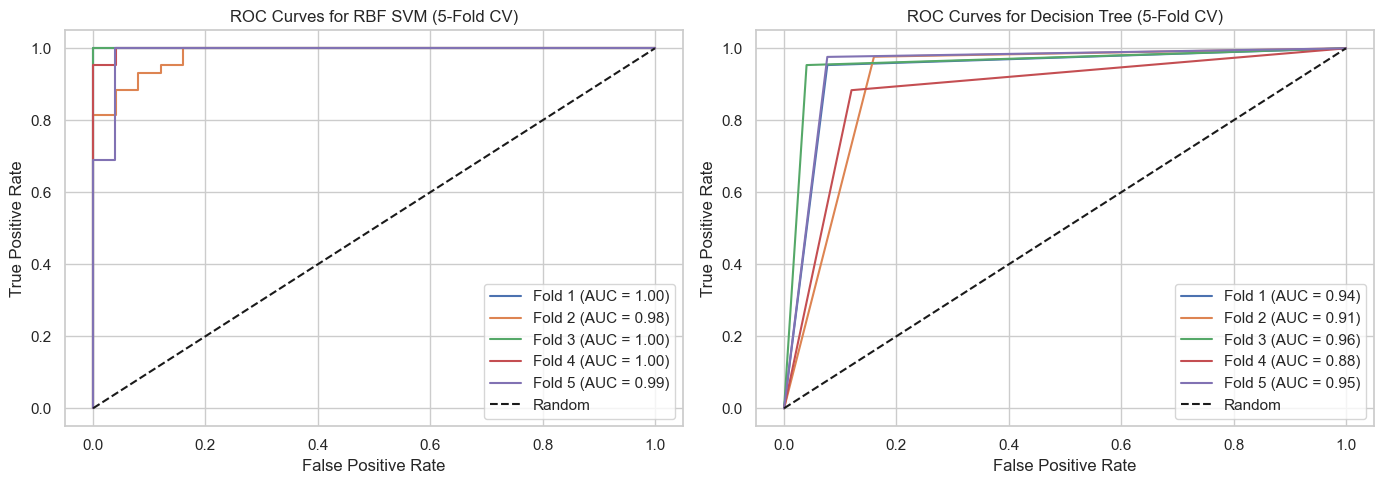

In [937]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.decomposition import PCA

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- RBF SVM ---
axs[0].set_title("ROC Curves for RBF SVM (5-Fold CV)")
for i, (fpr, tpr, roc_auc) in enumerate(rbf_roc_curves):
    axs[0].plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], 'k--', label='Random')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# --- Decision Tree ---
axs[1].set_title("ROC Curves for Decision Tree (5-Fold CV)")
for i, (fpr, tpr, roc_auc) in enumerate(dtree_roc_curves):
    axs[1].plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
axs[1].plot([0, 1], [0, 1], 'k--', label='Random')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.tight_layout()
plt.show()

The two ROC curve plots show that the kernelized SVM generalizes better than the decision tree. This is evident from the higher mean AUC and lower standard deviation across the folds for the SVM, indicating more consistent and reliable performance.

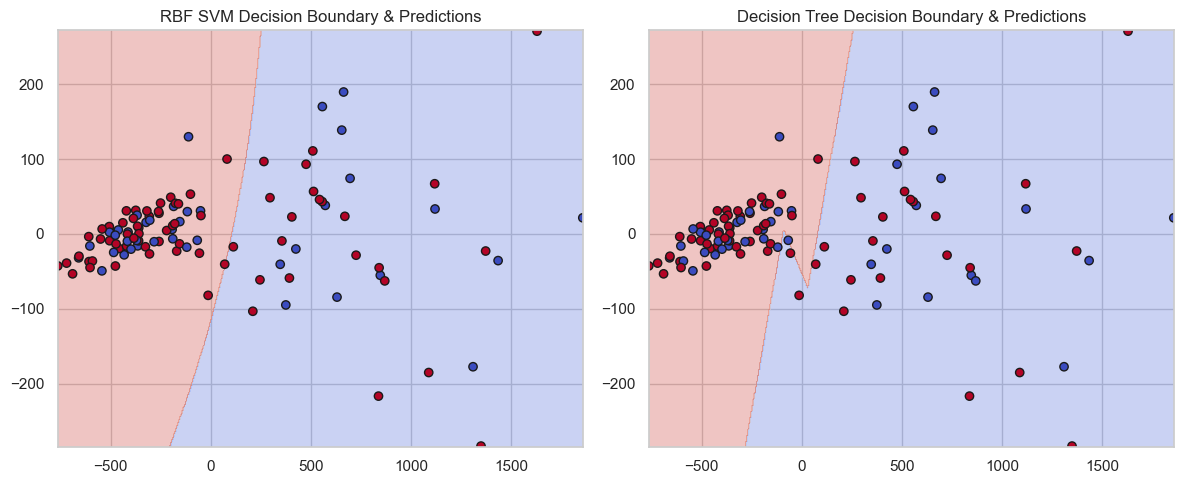

In [938]:
# Fit PCA on the original features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_val) 

# Create mesh grid in PCA space for decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Transform grid back to original feature space for prediction
grid_points = np.c_[xx.ravel(), yy.ravel()]

# IMPORTANT: Since models were trained on original features (not PCA),
# we need to inverse transform grid_points from PCA space back to original space
grid_original = pca.inverse_transform(grid_points)

# Step 5: Predict on grid points using each model
rbf_grid_preds = rbf_svm_model.predict(grid_original).reshape(xx.shape)
dtree_grid_preds = dtree_model.predict(grid_original).reshape(xx.shape)

plt.figure(figsize=(12, 5))

# RBF SVM plot
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, rbf_grid_preds, alpha=0.3, cmap='coolwarm')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=rbf_preds, cmap='coolwarm', edgecolor='k')
plt.title('RBF SVM Decision Boundary & Predictions')

# Decision Tree plot
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, dtree_grid_preds, alpha=0.3, cmap='coolwarm')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dtree_preds, cmap='coolwarm', edgecolor='k')
plt.title('Decision Tree Decision Boundary & Predictions')

plt.tight_layout()
plt.show()

The scatter plots show how each model separates the validation set when projected onto the first two principal components using PCA. The background colors indicate the decision boundaries in this reduced 2D space. Some points fall in the 'wrong' region either due to model misclassifications or because the lower-dimensional projection does not fully capture the original feature space.

In [939]:
# Extract AUC values (last element in each tuple)
auc_dtree = [roc_auc for _, _, roc_auc in dtree_roc_curves]
auc_rbf = [roc_auc for _, _, roc_auc in rbf_roc_curves]

t_test_models(auc_dtree, auc_rbf)

T-statistic: -4.794
P-value: 0.009
Statistically significant difference between the two models.


By conducting a t-test, we also find evidence of a statistically significant difference between the two models, indicating that the observed difference in performance is unlikely due to inherent variance or randomness.

### Q4.2 Discuss the trade-off between usability and accuracy for this dataset. Which model would you recommend for a medical decision-support system, and why? (Hint - Make use of F<sub>β</sub> score analysis) 
We begin by calculating the F<sub>β</sub> scores for the two models across β values from 1 to 5.

In [940]:
rbf_fb_score, dtree_fb_score = [], []

# Predict once per model
rbf_y_pred = rbf_svm_model.predict(X_test)
dtree_y_pred = dtree_model.predict(X_test)

# Compute Fβ scores for beta from 1 to 5
betas = [0.1, 0.5, 1, 2, 5]
for b in betas:
    rbf_fb_score.append(fbeta_score(y_test, rbf_y_pred, beta=b))
    dtree_fb_score.append(fbeta_score(y_test, dtree_y_pred, beta=b))

Then, we plot the F<sub>β</sub> scores for each model on a graph to visually compare their performance across different β values.

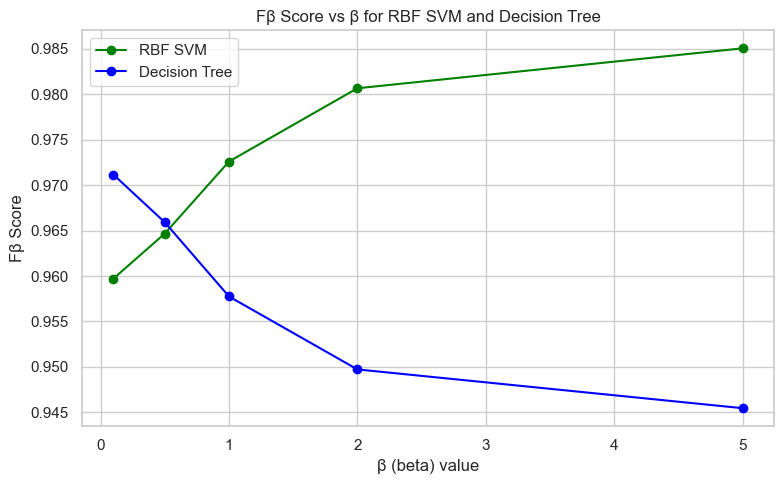

In [941]:
plt.figure(figsize=(8, 5))

plt.plot(betas, rbf_fb_score, marker='o', label='RBF SVM', color='green')
plt.plot(betas, dtree_fb_score, marker='o', label='Decision Tree', color='blue')

plt.xlabel('β (beta) value')
plt.ylabel('Fβ Score')
plt.title('Fβ Score vs β for RBF SVM and Decision Tree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The F<sub>β</sub> scores plot shows that the Decision Tree achieves higher scores at lower β values, indicating it has better precision. In contrast, the RBF SVM performs better at higher β values, suggesting it provides better recall. This behavior aligns with the definition of the F<sub>β</sub> score, where β < 1 emphasizes precision and β > 1 emphasizes recall.

Since the models are trained on breast cancer data, where missing a positive case (false negative) can have serious consequences, recall is more important than precision. Therefore, the RBF SVM is more suitable for deployment in a medical decision-support system for cancer detection.

### Q4.3 Use `GridSearchCV` with the training set to tune hyperparameters for both Decision Trees and SVMs. Confirm your final choice with the validation set. Summarize the best settings and provide relevant performance plots. 
We started by performing grid search for both models and validating their accuracies using the validation set.

In [942]:
# Decision Tree parameter grid
dtree_param_grid = {
    'd_tree__max_depth': list(range(1, 13)),
    'd_tree__min_samples_leaf': list(range(1, 13))
}

# Decision Tree GridSearch
dtree_grid = GridSearchCV(
    dtree_model,
    dtree_param_grid,
    cv=cross_validation,
    scoring='accuracy'
)
dtree_grid.fit(X_train, y_train)

print(f"Validation accuracy of the best decision tree model: {dtree_grid.best_estimator_.score(X_val, y_val):.3f}")

# SVM parameter grid
rbf_svm_param_grid = {
    'rbf_svm__C': [10**i for i in range(-2, 3)],
    'rbf_svm__gamma': [10**i for i in range(-4, 2)]
}

# SVM GridSearch
rbf_svm_grid = GridSearchCV(
    rbf_svm_model,
    rbf_svm_param_grid,
    cv=cross_validation,
    scoring='accuracy'
)
rbf_svm_grid.fit(X_train, y_train)

print(f"Validation accuracy of the best SVM model: {rbf_svm_grid.best_estimator_.score(X_val, y_val):.3f}")


Validation accuracy of the best decision tree model: 0.965
Validation accuracy of the best SVM model: 0.965


Then, we prepare the grid search results for visualization.

In [943]:
# --- Prepare Decision Tree data ---
dtree_results = dtree_grid.cv_results_
scores_dtree = dtree_results['mean_test_score']
max_depth = dtree_results['param_d_tree__max_depth'].data.astype(int)
min_samples_leaf = dtree_results['param_d_tree__min_samples_leaf'].data.astype(int)

df_dtree = pd.DataFrame({'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'score': scores_dtree})
pivot_dtree = df_dtree.pivot(index='min_samples_leaf', columns='max_depth', values='score')

# --- Prepare SVM data ---
svm_results = rbf_svm_grid.cv_results_
scores_svm = svm_results['mean_test_score']
C_values = svm_results['param_rbf_svm__C'].data.astype(float)
gamma_values = svm_results['param_rbf_svm__gamma'].data.astype(float)

df_svm = pd.DataFrame({'C': C_values, 'gamma': gamma_values, 'score': scores_svm})
pivot_svm = df_svm.pivot(index='gamma', columns='C', values='score')

Finally, we generate a heatmap for each model to highlight the optimal hyperparameter combinations.

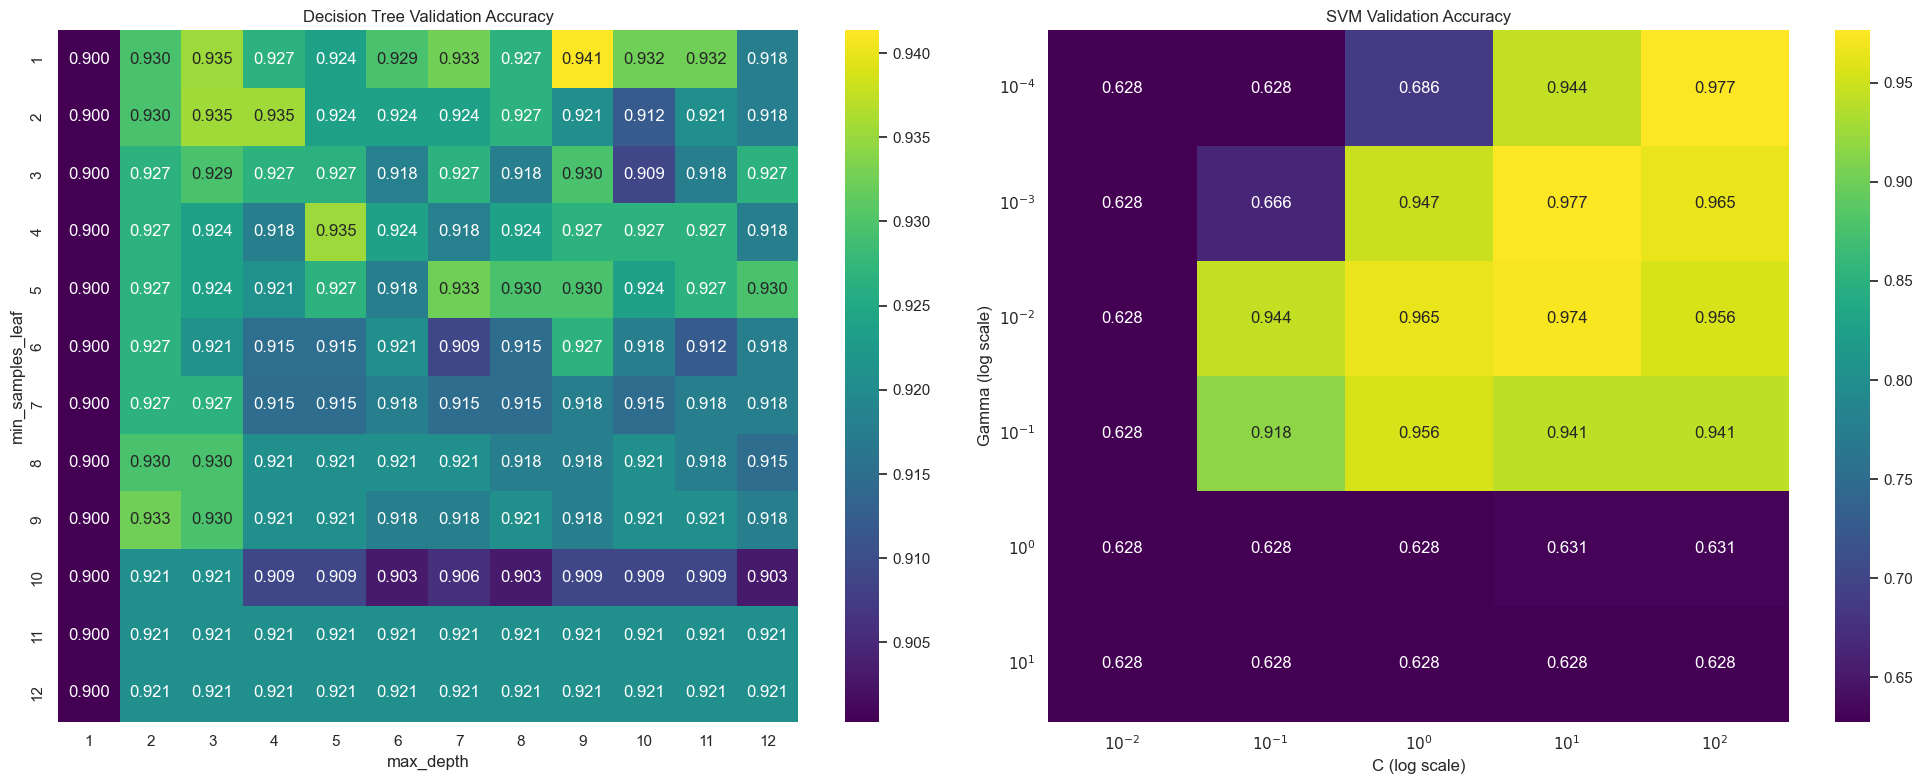

In [944]:
# --- Plot side by side ---
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Decision Tree heatmap
sns.heatmap(pivot_dtree, annot=True, fmt=".3f", cmap='viridis', ax=axs[0])
axs[0].set_title('Decision Tree Validation Accuracy')
axs[0].set_xlabel('max_depth')
axs[0].set_ylabel('min_samples_leaf')

# SVM heatmap
sns.heatmap(pivot_svm, annot=True, fmt=".3f", cmap='viridis', ax=axs[1])
axs[1].set_title('SVM Validation Accuracy')
axs[1].set_xlabel('C (log scale)')
axs[1].set_ylabel('Gamma (log scale)')

# Adjust SVM axis ticks to log scale labels
axs[1].set_xticks(np.arange(len(pivot_svm.columns)) + 0.5)
axs[1].set_xticklabels([f"$10^{{{int(np.log10(c))}}}$" for c in pivot_svm.columns])

axs[1].set_yticks(np.arange(len(pivot_svm.index)) + 0.5)
axs[1].set_yticklabels([f"$10^{{{int(np.log10(g))}}}$" for g in pivot_svm.index], rotation=0)

plt.tight_layout()
plt.show()

The best Decision Tree model achieved a validation accuracy of 0.947 with max depth = 6 and minimum leaf samples = 2. The best SVM model reached a higher accuracy of 0.965 with *C* = 1 and γ = 0.01. While Decision Tree results were stable, the SVM showed sharper sensitivity to hyperparameters and delivered better overall performance, making it the preferred model.

### Q4.4 Compare the final test set accuracy of the best Decision Tree and best SVM. Which model performs better in practice?
We start by finding the accuracies of the two best models on the test set.

In [945]:
# Predict on the test set
y_pred_dtree = dtree_grid.best_estimator_.predict(X_test)
y_pred_svm = rbf_svm_grid.best_estimator_.predict(X_test)


acc_dtree = accuracy_score(y_test, y_pred_dtree)
acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"Decision Tree accuracies: {acc_dtree:.3f}")
print(f"SVM accuracies: {acc_svm:.3f}")

Decision Tree accuracies: 0.930
SVM accuracies: 0.965


On the test set, the SVM model outperforms the Decision Tree, achieving an accuracy about 5% higher. This indicates that the SVM generalizes better to unseen data in this case.

### Q4.5 The Breast Cancer Wisconsin dataset has 30 continuous features, many of which are correlated and not linearly separable. Explain why a linear SVM might fail to capture complex patterns in this dataset. How does using an RBF kernel help in this case? Discuss your answer in terms of the dataset’s feature space and the geometry of the decision boundary.

The Breast Cancer dataset has many features that are correlated and not easily separated by a straight line. A linear SVM can’t capture these complex patterns because it only draws a simple straight boundary. The RBF kernel maps the data into a higher-dimensional space, allowing the SVM to create curved, flexible decision boundaries that better separate the classes.